# **Transfer Learning: Vision Transformers**

## Imports

In [15]:
from huggingface_hub import notebook_login
import os
import glob
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel, Array3D
from transformers import AutoFeatureExtractor, AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

## Config

In [16]:
DATA_DIR = "utility_poles_renamed"
MODEL_CKPT = "google/vit-base-patch16-224-in21k"
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

## Extract Path and Labels

In [17]:
image_paths = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
labels = sorted(set(os.path.basename(p).split('_')[0] for p in image_paths))
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

## Prepare HF dataset

In [18]:
data = [{"image_path": p, "label": label2id[os.path.basename(p).split('_')[0]]} for p in image_paths]
random.shuffle(data)
split = int(len(data) * 0.8)
ds = DatasetDict({
    "train": Dataset.from_list(data[:split]),
    "validation": Dataset.from_list(data[split:])
})

## Feature Extraction

In [19]:
processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

def transform(example):
    image = Image.open(example["image_path"]).convert("RGB")
    example["pixel_values"] = processor(images=image, return_tensors="np")["pixel_values"][0]
    return example

ds = ds.cast_column("image_path", Value("string"))
ds = ds.map(transform)
features = Features({
    "image_path": Value("string"),
    "label": ClassLabel(names=labels),
    "pixel_values": Array3D(dtype="float32", shape=(3, IMG_SIZE, IMG_SIZE))
})
ds = ds.cast(features)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Casting the dataset:   0%|          | 0/307 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/307 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/77 [00:00<?, ? examples/s]

## Modell

In [20]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Trainingsargumente

In [21]:
target_dir = "vit-utility-poles"
training_args = TrainingArguments(
    output_dir=target_dir,
    per_device_train_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=EPOCHS,
    learning_rate=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    run_name="vit-transferlearning-utility-poles"
)

## Metric Function

In [22]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def collate_fn(batch):
    pixel_values = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}


## Login Hugging Faces

In [23]:
notebook_login()

## Trainer

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,4.487866,0.025974,0.001676,0.025974,0.003148
2,No log,4.430106,0.038961,0.001756,0.038961,0.003360
3,No log,4.369073,0.064935,0.054933,0.064935,0.037879
4,No log,4.318738,0.077922,0.113434,0.077922,0.056463
5,3.939200,4.282239,0.116883,0.113302,0.116883,0.092610
6,3.939200,4.243982,0.129870,0.118661,0.129870,0.099827
7,3.939200,4.234069,0.116883,0.123903,0.116883,0.100107
8,3.939200,4.201342,0.155844,0.144904,0.155844,0.126241
9,3.939200,4.165778,0.168831,0.130118,0.168831,0.130322
10,2.504600,4.169477,0.142857,0.116825,0.142857,0.109828


C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

TrainOutput(global_step=400, training_loss=2.357845649719238, metrics={'train_runtime': 171.1167, 'train_samples_per_second': 35.882, 'train_steps_per_second': 2.338, 'total_flos': 4.762016747421696e+17, 'train_loss': 2.357845649719238, 'epoch': 20.0})

## Modell + Feature Extractor speichern

In [26]:
extractor = AutoFeatureExtractor.from_pretrained(MODEL_CKPT)
model.save_pretrained(training_args.output_dir)
extractor.save_pretrained(training_args.output_dir)

C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['vit-utility-poles\\preprocessor_config.json']

## Modell zur Hugging Face Hub hochladen

In [27]:
kwargs = {
    "finetuned_from": MODEL_CKPT,
    "dataset": "utility-poles-local",
    "tasks": "image-classification",
    "tags": ["image-classification"]
}

trainer.push_to_hub(**kwargs)

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gashiari/vit-utility-poles/commit/e92b5aae901bdb28d6c2249c60500588c2121553', commit_message='End of training', commit_description='', oid='e92b5aae901bdb28d6c2249c60500588c2121553', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gashiari/vit-utility-poles', endpoint='https://huggingface.co', repo_type='model', repo_id='gashiari/vit-utility-poles'), pr_revision=None, pr_num=None)

# Statistische Auswertung

## Vorhersagen für das Validierungsset

In [28]:
eval_preds = trainer.predict(ds["validation"])
y_true = eval_preds.label_ids
y_pred = np.argmax(eval_preds.predictions, axis=1)

C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Klassifikationsbericht

In [29]:
decoded_preds = [id2label[i] for i in y_pred]
decoded_true = [id2label[i] for i in y_true]
report = classification_report(decoded_true, decoded_preds)
print(report)

              precision    recall  f1-score   support

     Albania       0.00      0.00      0.00         1
   Argentina       0.00      0.00      0.00         1
   Australia       0.00      0.00      0.00         4
     Austria       0.11      1.00      0.20         1
  Bangladesh       0.00      0.00      0.00         2
     Belgium       0.00      0.00      0.00         1
      Bhutan       0.00      0.00      0.00         1
     Bolivia       0.00      0.00      0.00         1
      Bosnia       0.00      0.00      0.00         1
    Botswana       0.00      0.00      0.00         1
      Brazil       0.00      0.00      0.00         1
    Bulgaria       0.00      0.00      0.00         1
    Cambodia       0.00      0.00      0.00         1
      Canada       0.13      1.00      0.24         2
       Chile       0.00      0.00      0.00         2
    Colombia       0.00      0.00      0.00         0
       Czech       0.00      0.00      0.00         1
   Dominican       0.00    

C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\arija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

## Confusion Matrix

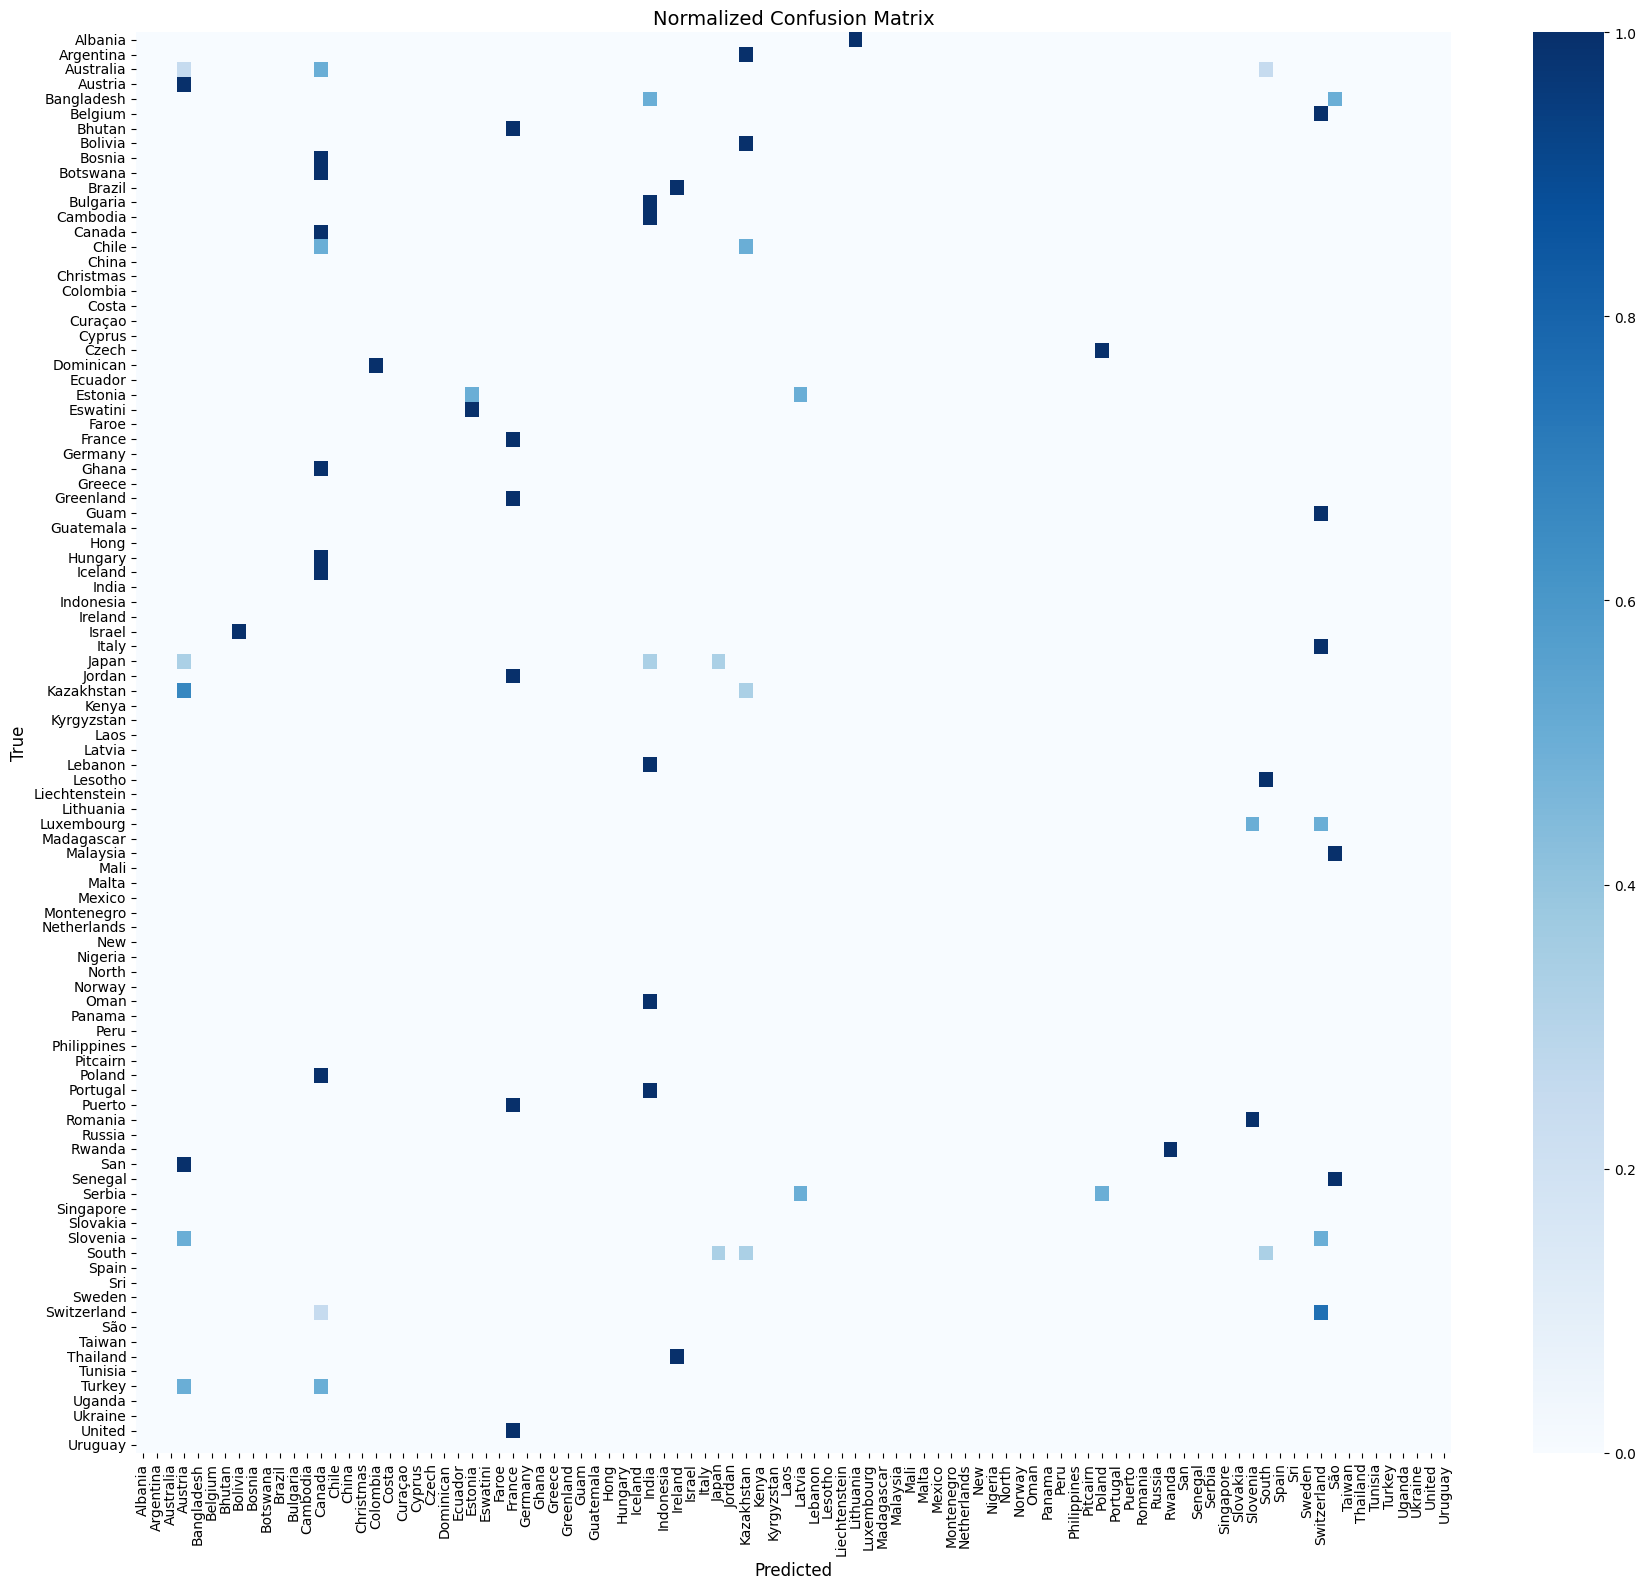

In [30]:
cm = confusion_matrix(decoded_true, decoded_preds, labels=labels, normalize='true')
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(cm, annot=False, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=True, ax=ax)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Normalized Confusion Matrix', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
os.makedirs("doc", exist_ok=True)
plt.tight_layout()
plt.savefig("doc/confusion_matrix.png")
plt.show()
